In [1]:
# basics
import os
import getpass
import intake
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import dask # memory-efficient parallel computation and delayed execution (lazy evaluation).

# map projections
import cartopy.crs as crs

# datashader plots
import pandas as pd
import datashader as ds
from datashader.mpl_ext import dsshow
import pyproj

# more colormaps
import cmocean


# fewer red warnings
import warnings, matplotlib
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

In [2]:
#import sys
#sys.executable

In [3]:
uid=getpass.getuser()
image_path=f"/scratch/{uid[0]}/{uid}/intake_demo_plots"
os.makedirs(image_path, exist_ok=True)
data_cache_path=f"/scratch/{uid[0]}/{uid}/intake_demo_data"
os.makedirs(data_cache_path, exist_ok=True)

In [4]:
def fix_time_axis(data):
    """Turn icon's yyyymmdd.f time axis into actual datetime format.

    This will fail for extreme values, but should be fine for a few centuries around today.
    """
    data['time'] = pd.to_datetime(["%8i" % x for x in data.time], format='%Y%m%d') + pd.to_timedelta([x%1 for x in data.time.values], unit='d')

In [5]:
def cache_data (data, filename):
    cache_file = os.path.join(data_cache_path, filename)
    if not  os.access(cache_file, os.R_OK):
        data  = data.compute()
        data.to_netcdf(cache_file)
    else:
        if type (data) == xr.core.dataarray.DataArray:
            data = xr.open_dataarray(cache_file)
        else:
            data = xr.open_dataset(cache_file)
    return data

In [6]:
def get_list_from_cat(catalog, column):
    """A helper function for getting the contents of a column in an intake catalog.

    Call with the catalog to be inspected and the column of interest."""
    return sorted(catalog.unique(column)[column]["values"])

In [7]:
catalog_file = "/work/ka1081/Catalogs/dyamond-nextgems.json"

In [8]:
cat = intake.open_esm_datastore(catalog_file)
cat

,unique
variable_id,649
project,2
institution_id,12
source_id,20
experiment_id,5
simulation_id,19
realm,6
frequency,18
time_reduction,5
grid_label,11


In [9]:
#cat.unique('simulation_id')

In [10]:
#get_list_from_cat(cat, 'variable_id')

In [11]:
varis = ['tas','rsds']
#hits = cat.search(simulation_id=['dpp0066', 'dpp0067'], variable_id=[var])
#hits = cat.search(simulation_id=['ngc2012'])
hits = cat.search(simulation_id=['ngc2012'], variable_id=varis, frequency="3hour")
#hits = cat.search(simulation_id=['ngc2009'], variable_id=[var])
#hits = cat.search(simulation_id=['ngc2009', 'ngc2012'])
#hits = cat.search(simulation_id=['ngc2009', 'ngc2012'], variable_id=[var])
#get_list_from_cat(hits, "variable_id")
#get_list_from_cat(cat, 'variable_id')

In [12]:
dataset_dict = hits.to_dataset_dict(cdf_kwargs={'chunks': dict(time=2, height=1,)})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institution_id.source_id.experiment_id.simulation_id.realm.frequency.time_reduction.grid_label.level_type'


In [13]:
all_atts = []
for name, data in dataset_dict.items():
    print(name)
    all_atts.extend(
        dict(variable_id=var, **data[var].attrs) for var in data.data_vars
    )  # we take the detour via dict and ** to add the variable name
frame = pd.DataFrame(all_atts)
frame


nextGEMS.MPI-M.ICON-ESM.nextgems_cycle2.ngc2012.atm.3hour.inst.gn.ml
nextGEMS.MPI-M.ICON-ESM.nextgems_cycle2.ngc2012.atm.3hour.mean.gn.ml


,variable_id,standard_name,long_name,units,param,CDI_grid_type,number_of_grid_in_reference
0,tas,tas,temperature in 2m,K,0.0.0,unstructured,1
1,rsds,surface_downwelling_shortwave_flux_in_air,surface downwelling shortwave radiation,W m-2,7.4.0,unstructured,1


In [14]:
data_dict = {}
for name, dataset in dataset_dict.items():
    print(name)
    #grid_file_path = "/pool/data/ICON" + dataset.attrs['grid_file_uri'].split('.de')[1]
    dataset.attrs['grid_file_uri'] = 'http://icon-downloads.mpimet.mpg.de/grids/public/mpim/0033/icon_grid_0033_R02B08_G.nc'
    grid_file_path = "/pool/data/ICON" + dataset.grid_file_uri.split('.de')[1]
    grid_data = xr.open_dataset(grid_file_path).rename(cell="ncells")
    data = xr.merge((dataset, grid_data))  
    #print('Hiiii')
    #fix_time_axis(data)
    #print('hello')
    data_dict[name] = data
    varname=dataset.intake_esm_varname[0]
    print(data[varname].shape)
    # print(data.rsds.shape)
    # print(data.tas.shape)
    #if '3hour' in name:
    #    ghi_3h = data

nextGEMS.MPI-M.ICON-ESM.nextgems_cycle2.ngc2012.atm.3hour.inst.gn.ml
(23911, 1, 5242880)
nextGEMS.MPI-M.ICON-ESM.nextgems_cycle2.ngc2012.atm.3hour.mean.gn.ml
(23911, 5242880)


In [15]:
# Extract mean ghi and inst temp
data_dict['nextGEMS.MPI-M.ICON-ESM.nextgems_cycle2.ngc2012.atm.3hour.inst.gn.ml'].tas.shape
#data_dict['nextGEMS.MPI-M.ICON-ESM.nextgems_cycle2.ngc2012.atm.3hour.mean.gn.ml'].rsds.shape
#ghi_3h.tas[4].shape
#ghi_3h.rsds[4].shape


(23911, 1, 5242880)

In [16]:
data_dict['nextGEMS.MPI-M.ICON-ESM.nextgems_cycle2.ngc2012.atm.3hour.inst.gn.ml']
#data_dict['nextGEMS.MPI-M.ICON-ESM.nextgems_cycle2.ngc2012.atm.3hour.mean.gn.ml'].time[4]

<xarray.Dataset>
Dimensions:                         (time: 23911, height: 1, ncells: 5242880,
                                     nv: 3, vertex: 2621442, ne: 6,
                                     edge: 7864320, no: 4, nc: 2,
                                     max_stored_decompositions: 4, two_grf: 2,
                                     cell_grf: 14, max_chdom: 1, edge_grf: 24,
                                     vert_grf: 13)
Coordinates:
  * height                          (height) float64 2.0
  * time                            (time) datetime64[ns] 2020-01-20 ... 2028...
    clon                            (ncells) float64 ...
    clat                            (ncells) float64 ...
    vlon                            (vertex) float64 ...
    vlat                            (vertex) float64 ...
    elon                            (edge) float64 ...
    elat                            (edge) float64 ...
Dimensions without coordinates: ncells, nv, vertex, ne, edge, no, nc,
                                max_stored_decompositions, two_grf, cell_grf,
                                max_chdom, edge_grf, vert_grf
Data variables: (12/92)
    tas                             (time, height, ncells) float32 dask.array<chunksize=(2, 1, 5242880), meta=np.ndarray>
    clon_vertices                   (ncells, nv) float64 ...
    clat_vertices                   (ncells, nv) float64 ...
    vlon_vertices                   (vertex, ne) float64 ...
    vlat_vertices                   (vertex, ne) float64 ...
    elon_vertices                   (edge, no) float64 ...
    ...                              ...
    edge_dual_normal_cartesian_x    (edge) float64 ...
    edge_dual_normal_cartesian_y    (edge) float64 ...
    edge_dual_normal_cartesian_z    (edge) float64 ...
    cell_circumcenter_cartesian_x   (ncells) float64 ...
    cell_circumcenter_cartesian_y   (ncells) float64 ...
    cell_circumcenter_cartesian_z   (ncells) float64 ...
Attributes: (12/14)
    uuidOfHGrid:             5aff0578-9bd9-11e8-8e4a-af3d880818e6
    grid_file_uri:           http://icon-downloads.mpimet.mpg.de/grids/public...
    intake_esm_varname:      ['tas']
    history:                 Wed Jun 29 11:38:22 2022: ncatted -a grid_file_u...
    source:                  git@gitlab.dkrz.de:icon/icon-aes.git@87a1eaded69...
    CDI:                     Climate Data Interface version 1.8.3rc (http://m...
    ...                      ...
    comment:                 Sapphire Dyamond (k203123) on l40680 (Linux 4.18...
    Conventions:             CF-1.6
    institution:             Max Planck Institute for Meteorology/Deutscher W...
    NCO:                     netCDF Operators version 5.0.6 (Homepage = http:...
    references:              see MPIM/DWD publications
    intake_esm_dataset_key:  nextGEMS.MPI-M.ICON-ESM.nextgems_cycle2.ngc2012....

## PV power modelling part


In [22]:
import pvlib
import pandas as pd
from collections import OrderedDict
#from pvlib.tracking import SingleAxisTracker
#from pvlib.pvsystem import PVSystem
#from pvlib.location import Location
#from pvlib.modelchain import ModelChain

In [65]:
lat = 48.210033 
lon = 16.363449
dt = pd.Timestamp(data_dict['nextGEMS.MPI-M.ICON-ESM.nextgems_cycle2.ngc2012.atm.3hour.inst.gn.ml'].time[4].item())
ghi = 100
temp = 40
ws=5
#def get_solar_comps(dt, lon, lat, ghi):
#    
#    df1 = pvlib.solarposition.spa_python(dt, lat, lon)
#    df2 = pvlib.irradiance.erbs(ghi, df1.zenith, dt)
#    print(df1.zenith)
#    return (df2['dni'][0], df2['dhi'][0])
    

In [23]:
lat = data_dict['nextGEMS.MPI-M.ICON-ESM.nextgems_cycle2.ngc2012.atm.3hour.inst.gn.ml'].clat
lon = data_dict['nextGEMS.MPI-M.ICON-ESM.nextgems_cycle2.ngc2012.atm.3hour.inst.gn.ml'].clon
dt = pd.Timestamp(data_dict['nextGEMS.MPI-M.ICON-ESM.nextgems_cycle2.ngc2012.atm.3hour.inst.gn.ml'].time[4].item())
ghi = data_dict['nextGEMS.MPI-M.ICON-ESM.nextgems_cycle2.ngc2012.atm.3hour.mean.gn.ml'].rsds[4]
temp = data_dict['nextGEMS.MPI-M.ICON-ESM.nextgems_cycle2.ngc2012.atm.3hour.inst.gn.ml'].tas[4].squeeze() - 273
#ws=5

In [30]:
#lat.shape
#ghi.shape
#temp.shape
powr = xr.DataArray(power, coords={'lat': ghi.clat, 'lon': ghi.clon}, dims=['latitude', 'longitude'])
#dt
#np.rad2deg(data_dict['nextGEMS.MPI-M.ICON-ESM.nextgems_cycle2.ngc2012.atm.3hour.inst.gn.ml'].clon.to_numpy())
#dni, dhi = get_solar_comps(dt, lon, lat, ghi)
#weather = pd.DataFrame([[ghi, dni, dhi, temp, ws]],
#                       columns=['ghi', 'dni', 'dhi', 'temp_air', 'wind_speed'],
#                       index=[dt])

ValueError: different number of dimensions on data and dims: 1 vs 2

In [ ]:
powr

In [24]:
#cec_modules = pvlib.pvsystem.retrieve_sam('CECMod')
#cec_modules
def spa_python(time, latitude, longitude,
               altitude=0, pressure=101325, temperature=12, delta_t=67.0,
               atmos_refract=None, how='numpy', numthreads=4, **kwargs):
    """
    Calculate the solar position using a python implementation of the
    NREL SPA algorithm.

    The details of the NREL SPA algorithm are described in [1]_.

    If numba is installed, the functions can be compiled to
    machine code and the function can be multithreaded.
    Without numba, the function evaluates via numpy with
    a slight performance hit.

    Parameters
    ----------
    time : pandas.DatetimeIndex
        Must be localized or UTC will be assumed.
    latitude : float
        Latitude in decimal degrees. Positive north of equator, negative
        to south.
    longitude : float
        Longitude in decimal degrees. Positive east of prime meridian,
        negative to west.
    altitude : float, default 0
        Distance above sea level.
    pressure : int or float, optional, default 101325
        avg. yearly air pressure in Pascals.
    temperature : int or float, optional, default 12
        avg. yearly air temperature in degrees C.
    delta_t : float, optional, default 67.0
        If delta_t is None, uses spa.calculate_deltat
        using time.year and time.month from pandas.DatetimeIndex.
        For most simulations specifing delta_t is sufficient.
        Difference between terrestrial time and UT1.
        *Note: delta_t = None will break code using nrel_numba,
        this will be fixed in a future version.*
        The USNO has historical and forecasted delta_t [3].
    atmos_refrac : None or float, optional, default None
        The approximate atmospheric refraction (in degrees)
        at sunrise and sunset.
    how : str, optional, default 'numpy'
        Options are 'numpy' or 'numba'. If numba >= 0.17.0
        is installed, how='numba' will compile the spa functions
        to machine code and run them multithreaded.
    numthreads : int, optional, default 4
        Number of threads to use if how == 'numba'.

    Returns
    -------
    DataFrame
        The DataFrame will have the following columns:
        apparent_zenith (degrees),
        zenith (degrees),
        apparent_elevation (degrees),
        elevation (degrees),
        azimuth (degrees),
        equation_of_time (minutes).


    References
    ----------
    .. [1] I. Reda and A. Andreas, Solar position algorithm for solar
       radiation applications. Solar Energy, vol. 76, no. 5, pp. 577-589, 2004.

    .. [2] I. Reda and A. Andreas, Corrigendum to Solar position algorithm for
       solar radiation applications. Solar Energy, vol. 81, no. 6, p. 838,
       2007.

    .. [3] USNO delta T:
       http://www.usno.navy.mil/USNO/earth-orientation/eo-products/long-term

    See also
    --------
    pyephem, spa_c, ephemeris
    """

    # Added by Tony Lorenzo (@alorenzo175), University of Arizona, 2015

    lat = latitude
    lon = longitude
    elev = altitude
    pressure = pressure / 100  # pressure must be in millibars for calculation

    atmos_refract = atmos_refract or 0.5667

    if not isinstance(time, pd.DatetimeIndex):
        try:
            time = pd.DatetimeIndex(time)
        except (TypeError, ValueError):
            time = pd.DatetimeIndex([time, ])

    unixtime = np.array(time.astype(np.int64)/10**9)

    spa = _spa_python_import(how)

    delta_t = delta_t or spa.calculate_deltat(time.year, time.month)

    app_zenith, zenith, app_elevation, elevation, azimuth, eot = \
        spa.solar_position(unixtime, lat, lon, elev, pressure, temperature,
                           delta_t, atmos_refract, numthreads)

    eot = np.full(zenith.shape, np.asscalar(eot))
    #print(azimuth.shape)
    #print(eot.shape)
    #print(zenith.shape)
    result = pd.DataFrame({'apparent_zenith': app_zenith, 'zenith': zenith,
                           'apparent_elevation': app_elevation,
                           'elevation': elevation, 'azimuth': azimuth,
                           'equation_of_time': eot},)

    return result

def _spa_python_import(how):
    """Compile spa.py appropriately"""

    from pvlib import spa

    # check to see if the spa module was compiled with numba
    using_numba = spa.USE_NUMBA

    if how == 'numpy' and using_numba:
        # the spa module was compiled to numba code, so we need to
        # reload the module without compiling
        # the PVLIB_USE_NUMBA env variable is used to tell the module
        # to not compile with numba
        warnings.warn('Reloading spa to use numpy')
        os.environ['PVLIB_USE_NUMBA'] = '0'
        spa = reload(spa)
        del os.environ['PVLIB_USE_NUMBA']
    elif how == 'numba' and not using_numba:
        # The spa module was not compiled to numba code, so set
        # PVLIB_USE_NUMBA so it does compile to numba on reload.
        warnings.warn('Reloading spa to use numba')
        os.environ['PVLIB_USE_NUMBA'] = '1'
        spa = reload(spa)
        del os.environ['PVLIB_USE_NUMBA']
    elif how != 'numba' and how != 'numpy':
        raise ValueError("how must be either 'numba' or 'numpy'")

    return spa

def clearness_index(ghi, solar_zenith, extra_radiation, min_cos_zenith=0.065,
                    max_clearness_index=2.0):
    """
    Calculate the clearness index.

    The clearness index is the ratio of global to extraterrestrial
    irradiance on a horizontal plane [1]_.

    Parameters
    ----------
    ghi : numeric
        Global horizontal irradiance in W/m^2.

    solar_zenith : numeric
        True (not refraction-corrected) solar zenith angle in decimal
        degrees.

    extra_radiation : numeric
        Irradiance incident at the top of the atmosphere

    min_cos_zenith : numeric, default 0.065
        Minimum value of cos(zenith) to allow when calculating global
        clearness index `kt`. Equivalent to zenith = 86.273 degrees.

    max_clearness_index : numeric, default 2.0
        Maximum value of the clearness index. The default, 2.0, allows
        for over-irradiance events typically seen in sub-hourly data.
        NREL's SRRL Fortran code used 0.82 for hourly data.

    Returns
    -------
    kt : numeric
        Clearness index

    References
    ----------
    .. [1] Maxwell, E. L., "A Quasi-Physical Model for Converting Hourly
           Global Horizontal to Direct Normal Insolation", Technical
           Report No. SERI/TR-215-3087, Golden, CO: Solar Energy Research
           Institute, 1987.
    """
    cos_zenith = tools.cosd(solar_zenith)
    I0h = extra_radiation * np.maximum(cos_zenith, min_cos_zenith)
    # consider adding
    # with np.errstate(invalid='ignore', divide='ignore'):
    # to kt calculation, but perhaps it's good to allow these
    # warnings to the users that override min_cos_zenith
    kt = ghi / I0h
    kt = np.maximum(kt, 0)
    kt = np.minimum(kt, max_clearness_index)
    return kt

def erbs(ghi, zenith, datetime_or_doy, min_cos_zenith=0.065, max_zenith=87):
    r"""
    Estimate DNI and DHI from GHI using the Erbs model.

    The Erbs model [1]_ estimates the diffuse fraction DF from global
    horizontal irradiance through an empirical relationship between DF
    and the ratio of GHI to extraterrestrial irradiance, Kt. The
    function uses the diffuse fraction to compute DHI as

    .. math::

        DHI = DF \times GHI

    DNI is then estimated as

    .. math::

        DNI = (GHI - DHI)/\cos(Z)

    where Z is the zenith angle.

    Parameters
    ----------
    ghi: numeric
        Global horizontal irradiance in W/m^2.
    zenith: numeric
        True (not refraction-corrected) zenith angles in decimal degrees.
    datetime_or_doy : int, float, array, pd.DatetimeIndex
        Day of year or array of days of year e.g.
        pd.DatetimeIndex.dayofyear, or pd.DatetimeIndex.
    min_cos_zenith : numeric, default 0.065
        Minimum value of cos(zenith) to allow when calculating global
        clearness index `kt`. Equivalent to zenith = 86.273 degrees.
    max_zenith : numeric, default 87
        Maximum value of zenith to allow in DNI calculation. DNI will be
        set to 0 for times with zenith values greater than `max_zenith`.

    Returns
    -------
    data : OrderedDict or DataFrame
        Contains the following keys/columns:

            * ``dni``: the modeled direct normal irradiance in W/m^2.
            * ``dhi``: the modeled diffuse horizontal irradiance in
              W/m^2.
            * ``kt``: Ratio of global to extraterrestrial irradiance
              on a horizontal plane.

    References
    ----------
    .. [1] D. G. Erbs, S. A. Klein and J. A. Duffie, Estimation of the
       diffuse radiation fraction for hourly, daily and monthly-average
       global radiation, Solar Energy 28(4), pp 293-302, 1982. Eq. 1

    See also
    --------
    dirint
    disc
    """

    dni_extra = pvlib.irradiance.get_extra_radiation(datetime_or_doy)
    dni_extra = np.full(ghi.shape, dni_extra)
    #kt = clearness_index(ghi, zenith, dni_extra, min_cos_zenith=min_cos_zenith,
    #                     max_clearness_index=1)
    kt = pvlib.irradiance.clearness_index(ghi, zenith, dni_extra, min_cos_zenith=min_cos_zenith,
                         max_clearness_index=1)

    # For Kt <= 0.22, set the diffuse fraction
    df = 1 - 0.09*kt

    # For Kt > 0.22 and Kt <= 0.8, set the diffuse fraction
    df = np.where((kt > 0.22) & (kt <= 0.8),
                  0.9511 - 0.1604*kt + 4.388*kt**2 -
                  16.638*kt**3 + 12.336*kt**4,
                  df)

    # For Kt > 0.8, set the diffuse fraction
    df = np.where(kt > 0.8, 0.165, df)

    dhi = df * ghi

    dni = (ghi - dhi) / pvlib.tools.cosd(zenith)
    bad_values = (zenith > max_zenith) | (ghi < 0) | (dni < 0)
    dni = np.where(bad_values, 0, dni)
    # ensure that closure relationship remains valid
    dhi = np.where(bad_values, ghi, dhi)

    #data = OrderedDict()
    #data['dni'] = dni
    #data['dhi'] = dhi
    #data['kt'] = kt

    #if isinstance(datetime_or_doy, pd.DatetimeIndex):
    #    data = pd.DataFrame(data, index=datetime_or_doy)

    return dni, dhi

In [25]:
def calc_pow_per_kw(dt, lon, lat, ghi, temp):

    #location = pvlib.location.Location(latitude=lat, longitude=lon)
    # Get solar position
    #sol_pos = pvlib.solarposition.spa_python(dt, lat, lon)
    sol_pos = spa_python(dt, lat, lon)
    #df1 = pvlib.solarposition.spa_python(dt, lat, lon)
    # Split GHI into DHI and DNI
    #surf_irrads = pvlib.irradiance.erbs(ghi, sol_pos.zenith, dt)
    dni, dhi = erbs(ghi, sol_pos.zenith, dt)
    #print(df1.zenith)
    #dni = surf_irrads['dni'][0]
    #dhi = surf_irrads['dhi'][0]
    #plt.figure()
    #plt.hist(dni)
    #plt.scatter(lon, lat, c=ghi, s=2, cmap='inferno')
    #plt.colorbar()
    #plt.title(name)
    print(ghi)
    print(dhi)
    print(dni)
    # Calculate AOI
    aoi = pvlib.irradiance.aoi(lat, 180, sol_pos.zenith, sol_pos.azimuth)
    # Calculate ground reflected irradiance
    grnd = pvlib.irradiance.get_ground_diffuse(lat, ghi, albedo=0.25, surface_type=None)
    # Convert DHI to DTI
    dti = pvlib.irradiance.klucher(lat, 180, dhi, ghi, sol_pos.zenith, sol_pos.azimuth)
    # Calculate GTI
    irrads = pvlib.irradiance.poa_components(aoi, dni, dti, grnd)
    #print(irrads)
    gti = irrads['poa_global']
    # Convert GTI to DC
    dc = pvlib.pvsystem.pvwatts_dc(gti, temp, 1, -0.0035)
    # Convert DC to AC
    ac = pvlib.inverter.pvwatts(dc, 1)
    #print(aoi)
    #print(dti)
    #print(grnd)
    #print(gti)
    #print(dc)
    #print(ac)
    #system = PVSystem(surface_tilt=lat, surface_azimuth=180,
    #              temperature_model_parameters=dict(a=-3.56, b=-0.075, deltaT=3),
    #              module_parameters=cec_module,
    #              inverter_parameters=cec_inverter)
    #mc = ModelChain(system, location)
    #mc.run_model(weather=weather)
    return ac

vfunc = np.vectorize(calc_pow_per_kw)

In [243]:
cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
cec_inverter = cec_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']
#cec_modules = pvlib.pvsystem.retrieve_sam('CECMod')
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
sandia_module = sandia_modules['SolarWorld_Sunmodule_250_Poly__2013_']
#cec_module = cec_modules['Zytech_Solar_ZT275P']

def calc_pow_per_kw(lon, lat, ghi, temp, ws):

    location = Location(latitude=lat, longitude=lon)
    
    system = PVSystem(surface_tilt=lat, surface_azimuth=180,
                  temperature_model_parameters=dict(a=-3.56, b=-0.075, deltaT=3),
                  module_parameters=cec_module,
                  inverter_parameters=cec_inverter)
    mc = ModelChain(system, location)
    mc.run_model(weather=weather)
    return mc

In [103]:
#sandia_modules
lon

<xarray.DataArray 'clon' (ncells: 5242880)>
array([1.27409 , 1.27409 , 1.272124, ..., 1.331804, 1.333295, 1.335099])
Coordinates:
    clon     (ncells) float64 1.274 1.274 1.272 1.276 ... 1.332 1.333 1.335
    clat     (ncells) float64 0.9182 0.9196 0.9175 ... -0.7892 -0.787 -0.7891
Dimensions without coordinates: ncells
Attributes:
    long_name:      center longitude
    units:          radian
    standard_name:  grid_longitude
    bounds:         clon_vertices

In [26]:
power = calc_pow_per_kw(dt, np.rad2deg(lon.to_numpy()), np.rad2deg(lat.to_numpy()),
                                                   ghi.to_numpy(), temp.to_numpy())
#power = vfunc(dt, lon, lat, ghi, temp)

/home/b/b309230/.local/lib/python3.9/site-packages/pvlib/spa.py:1143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.array(result)
/tmp/ipykernel_1658929/4069393869.py:105: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  eot = np.full(zenith.shape, np.asscalar(eot))


[ 50.473057  49.854023  51.156025 ... 167.5663   160.96228  156.59071 ]
[ 50.47305679  49.85402298  51.15602493 ... 161.42511384 155.81390425
 151.99076272]
[ 0.          0.          0.         ... 14.23171296 11.9605434
 10.71204394]


In [32]:
powr = xr.DataArray(power, coords={'lat': ghi.clat, 'lon': ghi.clon}, dims=['ncells'])


In [33]:
powr

<xarray.DataArray 'poa_global' (ncells: 5242880)>
array([0.04161515, 0.04105045, 0.04222212, ..., 0.14524376, 0.13950215,
       0.13566404])
Coordinates:
    lat      (ncells) float64 ...
    lon      (ncells) float64 ...
Dimensions without coordinates: ncells

(array([3308853.,  391175.,  271411.,  237965.,  210675.,  186739.,
         154470.,  135254.,  161006.,  185332.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

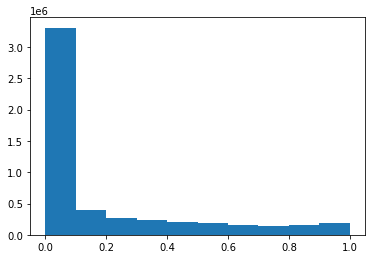

In [155]:
import matplotlib.pyplot as plt
plt.hist(power, range=(0,1))

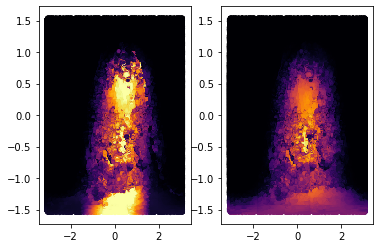

In [157]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2)
skip=64
ax[0].scatter(data.clon, data.clat, c=power, s=2, cmap='inferno')
ax[1].scatter(data.clon, data.clat, c=ghi, s=2, cmap='inferno')
#plt.scatter(data.clon[::skip], data.clat[::skip], c=power[::skip], s=2, cmap='inferno')
# t=0 is garbage data, so we take t=1 with the [1] and the only level with the[0], see shape of tas above.
#plt.colorbar()
#plt.title(name)

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


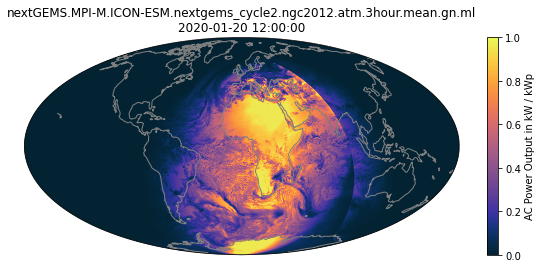

In [39]:
# Very fast plotting on projected maps with Pandas and Datashader


def transform_coords(data, projection):
    """Projects coordinates of the dataset into the desired map projection.

    Expects data.lon to be the longitudes and data.lat to be the latitudes

    """
    lon = np.rad2deg(data['lon'])
    lat = np.rad2deg(data['lat'])
    #if "rad" in data.lon.units:  # icon comes in radian, ifs in degree.
    #    lon = np.rad2deg(data.lon)
    #    lat = np.rad2deg(data.lat)
    coords = (
        projection.transform_points(  # This re-projects our data to the desired grid.
            crs.Geodetic(), lon, lat
        )
    )
    return coords


def plot_map(
    data,
    projection,
    coords=None,  # we can compute them ourselves, if given data with lat and lon attached.
    colorbar_label="",
    title="",
    coastlines=True,
    extent=None,
    **kwargs,
):
    """Use datashader to plot a dataset from a pandas dataframe with a given projection.

    Required: data and projection.
    All other arguments are optional. Additional arguments will be passed directly to the plot routine (dsshow).
    """

    # If we are not given projected data, we project it ourselves.
    if coords is None:
        coords = projection.transform_points(crs.Geodetic(), data.lon, data.lat)

    # For datashader, we need the data in a pandas dataframe object.
    df = pd.DataFrame(
        data={
            "val": np.squeeze(
                data
            ),  # here we select which data to plot! - the squeeze removes empty dimensions.
            "x": coords[:, 0],  # from the projection above
            "y": coords[:, 1],  # from the projection above
        }
    )

    # the basis for map plotting.
    fig, ax = plt.subplots(figsize=(10, 4), subplot_kw={"projection": projection})
    fig.canvas.draw_idle()  # necessary to make things work

    # the plot itself
    artist = dsshow(df, ds.Point("x", "y"), ds.mean("val"), ax=ax, **kwargs)

    # making things pretty
    plt.title(title)
    if coastlines:
        ax.coastlines(color="grey")
    fig.colorbar(artist, label=colorbar_label)

    # for regional plots:
    if extent is not None:
        ax.set_extent(extent)

    return fig

projection = (
    crs.Mollweide()
)  # We will plot in mollweide projection - needs to match the plot calls later.

# We store all coordinates in a dictionary for later use.
coords = transform_coords(powr, projection)

# Plotting the projected data
dt = pd.Timestamp(data_dict['nextGEMS.MPI-M.ICON-ESM.nextgems_cycle2.ngc2012.atm.3hour.inst.gn.ml'].time[4].item())
# level = 0 # there is only level 0 in tas

#for name, data in data_dict.items():
#    var = data.intake_esm_varname[
#        0
#    ]  # variable names vary a bit by model. Here we get the correct one.
#    timestr = str(dt)[
#        :-10
#    ]  # take the correct time and remove trailing zeros
fig = plot_map(data=powr,  # our data for the plot
        projection=projection,  # generated in the cell above.
        coords=coords,  # generated in the cell above.
        cmap=cmocean.cm.thermal,  # nice colorbar for temperature
        vmin=0,  # minimum for the plot ~-33C
        vmax=1,  # maximum for the plot ~37C
        colorbar_label="AC Power Output in kW / kWp",
        title=f"{name}\n{str(dt)}",  # dataset name and time stamp.
    )
    #filename = f"{image_path}/{var}_datashader_mollweide_{name}_{re.sub(':','',timestr)}.png"  # save to /scratch/
    #print("saving to ", filename)
#plt.savefig(filename)


In [37]:
powr['lon']

<xarray.DataArray 'lon' (ncells: 5242880)>
[5242880 values with dtype=float64]
Coordinates:
    lat      (ncells) float64 ...
    lon      (ncells) float64 ...
Dimensions without coordinates: ncells
Attributes:
    long_name:      center longitude
    units:          radian
    standard_name:  grid_longitude
    bounds:         clon_vertices